In [25]:
%load_ext autoreload
%autoreload 2


In [26]:
import weather_routing
import plot_isochron_routes
import pandas
import math

In [2]:
year = 2024
##################
min_lat = 21.1
max_lat = 34.1
max_lng = -118
min_lng = -158
# Waypoints for the TransPac 
waypoints = pandas.DataFrame([
    (33.69853, -118.25085, 'Pt. Fermin Bouy'),
    (33.48177, -118.64101, 'Catalina West End'),
    #(21.24296, -157.81775, 'Diamond Head Bouy'),
            ], columns=['lat', 'lng', 'name'])
# July 1st, 12:00 PST
Start_Date = f"{year}0701"
Start_Time = 19 #19:00 UTC
##################
#grib_files_dir = "historical_gribs/2024"
wind_data_dir = f"historical_wind_data/{year}"

In [74]:
from geopy.distance import geodesic


ModuleNotFoundError: No module named 'geopy'

In [3]:
waypoints

,lat,lng,name
0,33.69853,-118.25085,Pt. Fermin Bouy
1,33.48177,-118.64101,Catalina West End


In [7]:
rhumb_route = weather_routing.route_shortest_path(waypoints, hour_offset=0, start_date=Start_Date, start_time=Start_Time, 
                        wind_data_dir=wind_data_dir,gps_bounds=None,
                        max_deg_deviation_from_rhumb=90)

Pt. Fermin Bouy at 2024-07-01 11:00:00-07:00
starting time: 20240701 18 2024-07-01 11:00:00-07:00
0: twa=132.2 mag=202.2 dtg=19.8 sog=4.7
1: twa=132.2 mag=206.3 dtg=16.3 sog=4.7
2: twa=135 mag=217.5 dtg=13.0 sog=4.4
3: twa=150 mag=237.7 dtg=10.1 sog=3.5
4: twa=150 mag=299.6 dtg=7.1 sog=3.5
5: twa=165 mag=257.4 dtg=4.2 sog=2.9
6: twa=165 mag=277.5 dtg=1.5 sog=2.9
7: twa=180 mag=250.8 dtg=1.1 sog=2.6
Catalina West End at 2024-07-01 19:00:00-07:00
route calculated in 2.0s


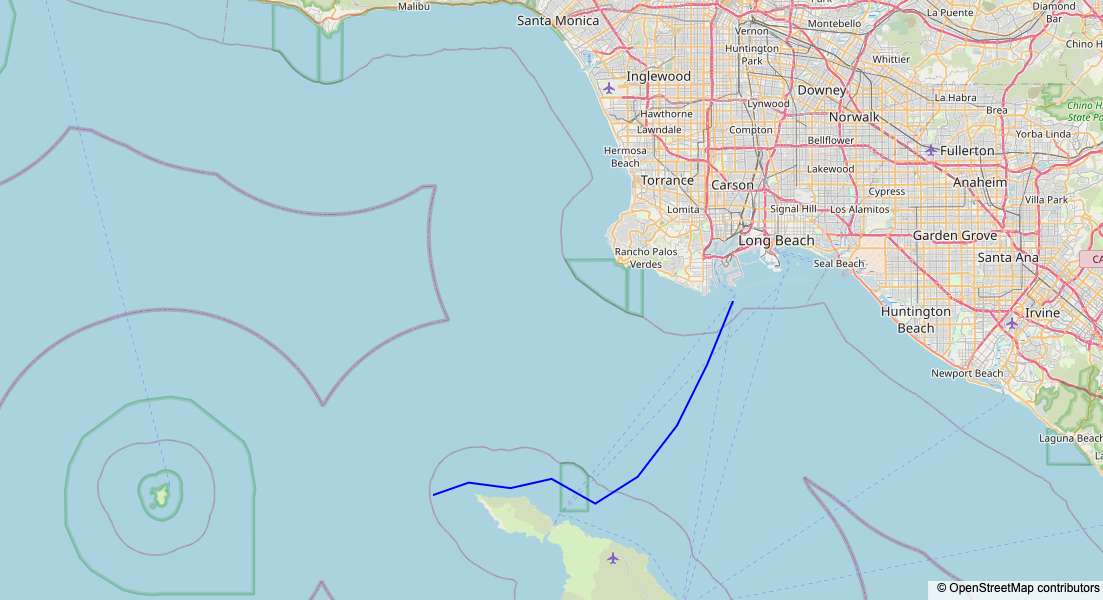

In [28]:
plot_isochron_routes.plot_isochron_routes(rhumb_route=rhumb_route)

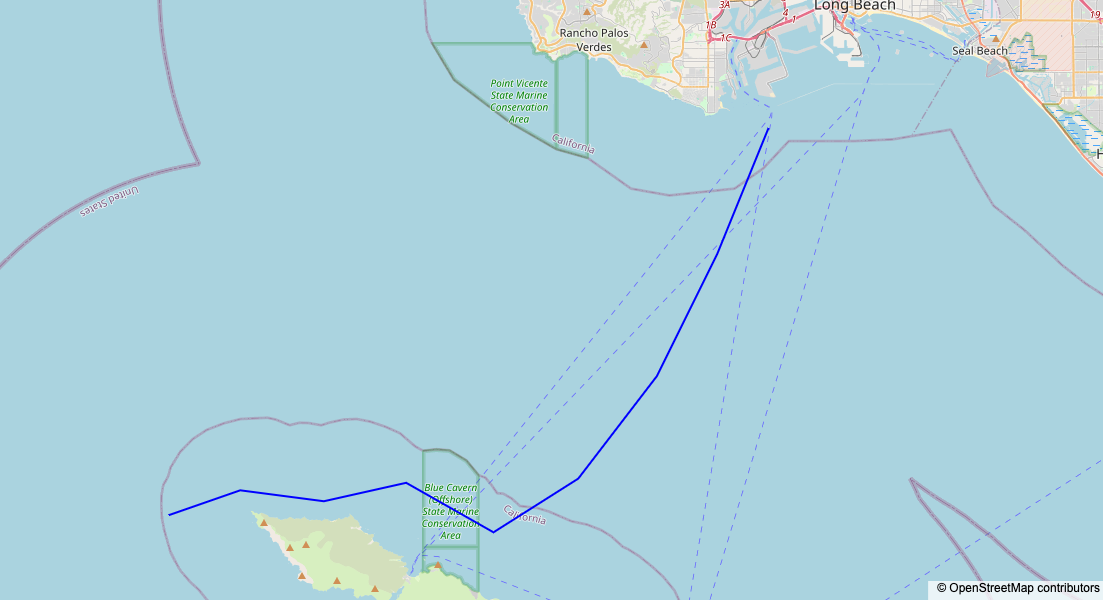

In [34]:
plot_isochron_routes.plot_route(rhumb_route, color='blue')

In [65]:
isochrons = weather_routing.route_isochrons(waypoints,start_date=Start_Date, start_time=Start_Time, wind_data_dir=wind_data_dir)

========== routing to waypoint 1 ===========
Calculating simulation_time=1
  dtw=19.762 sog=4.680 #routes=6 time=0.00
Calculating simulation_time=2
  dtw=16.299 sog=4.680 #routes=14 time=0.01
Calculating simulation_time=3
  dtw=12.767 sog=4.680 #routes=17 time=0.02
Calculating simulation_time=4
  dtw=8.852 sog=5.620 #routes=24 time=0.02
Calculating simulation_time=5
  dtw=4.925 sog=4.680 #routes=28 time=0.05
Calculating simulation_time=6
  dtw=0.937 sog=4.680 #routes=28 time=0.03 === found waypoint


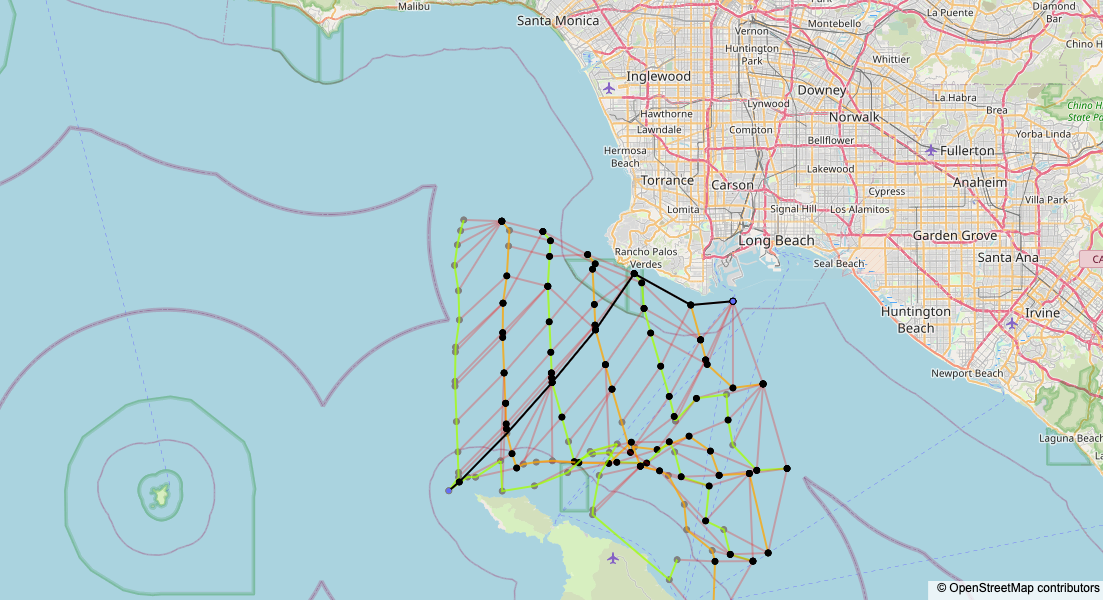

In [66]:
plot_isochron_routes.plot_isochron_routes(isochrons=isochrons, waypoints=waypoints, min_route=isochrons[-1][0])

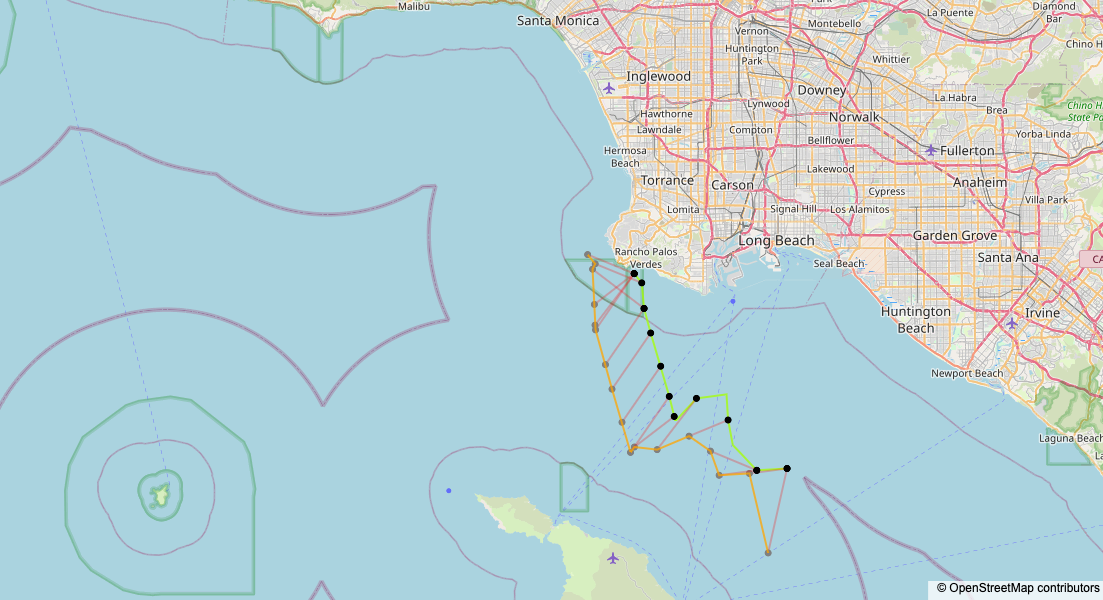

In [73]:
plot_isochron_routes.plot_isochron_routes(isochrons=isochrons[2:4], waypoints=waypoints)

In [59]:
import numpy



def angle_between_segments(p1, p2, p3):
    def latlon_to_cartesian(lat, lon):
        lat, lon = numpy.radians(lat), numpy.radians(lon)
        x = numpy.cos(lat) * numpy.cos(lon)
        y = numpy.cos(lat) * numpy.sin(lon)
        z = numpy.sin(lat)
        return numpy.array([x, y, z])
    v1 = latlon_to_cartesian(*p1) - latlon_to_cartesian(*p2)
    v2 = latlon_to_cartesian(*p3) - latlon_to_cartesian(*p2)
    
    cos_angle = numpy.dot(v1, v2) / (numpy.linalg.norm(v1) * numpy.linalg.norm(v2))
    cos_angle = numpy.clip(cos_angle, -1.0, 1.0)  # Avoid numerical errors
    
    return numpy.degrees(numpy.arccos(cos_angle))

# Example usage
p3 = (34.0522, -118.2437)  # Los Angeles
p2 = (36.7783, -119.4179)  # California center
p1 = (40.7128, -74.0060)   # New York

angle = angle_between_segments(p1, p2, p3)
print(f"Angle: {angle:.2f} degrees")

Angle: 90.52 degrees


In [62]:
# Example usage
p1 = (33.0, -118)  
p2 = (33.0, -119)
p3 = (34.0, -119) 
angle = angle_between_segments(p1, p2, p3)
print(f"Angle: {angle:.2f} degrees")

Angle: 89.72 degrees
